# Imports, functions and classes

## Imports

In [20]:
import os
import math
import time
import torch
import numpy as np
from PIL import Image
import json
from datetime import datetime
import torch.nn as nn
from torch import optim
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import itertools
import pandas as pd
!pip install -q torchsummary
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import matplotlib.pyplot as plt

## Adder dataloader


---


General adder to define dataloader automatically based on Nbits

In [23]:
import pandas as pd
def NAND(x, y):
     if x == 0 and y == 0: return 1
     if x == 0 and y == 1: return 1
     if x == 1 and y == 0: return 1
     if x == 1 and y == 1: return 0

def NOT(x):
     return NAND(x, x)

def AND(x, y):
     return NOT(NAND(x, y))

def OR(x, y):
     return NAND(NAND(x, x), NAND(y, y))

def XOR(x, y):
     return AND(OR(x, y),
                NOT(AND(x, y)))

def HALF(x, y):
     carry = AND(x, y)
     sum = XOR(x, y)
     return (carry, sum)

def FULL(x, y, carry_in):
     carry1, sum1 = HALF(x, y)
     carry2, sum2 = HALF(carry_in, sum1)
     carry_out = OR(carry1, carry2)
     return (carry_out, sum2)

def ADDN(left, right, carry_in):
    N = len(left)
    sums = []
    carry = carry_in

    for i in range(N-1, -1, -1):
        carry, sum_ = FULL(left[i], right[i], carry)
        sums.insert(0, sum_)

    return sums + [carry]


def generate_adder_dataframe(N, add_constant=True, constant_value=1):
    inputs = [
        [*bin(i)[2:].zfill(N), *bin(j)[2:].zfill(N), carry_in]
        for i in range(2**N)
        for j in range(2**N)
        for carry_in in range(2)
    ]

    inputs = [[int(x) for x in row] for row in inputs]

    outputs = [ADDN(row[:N], row[N:2*N], row[2*N]) for row in inputs]

    in_columns = [f"a{i}" for i in range(1, N+1)] + [f"b{i}" for i in range(1, N+1)] + ["carry_in"]
    out_columns = [f"sum{i}" for i in range(1, N+1)] + ["carry_out"]

    in_df = pd.DataFrame(inputs, columns=in_columns)
    if add_constant:
      in_df["Constant"] = constant_value
    out_df = pd.DataFrame(outputs, columns=out_columns)
    return pd.concat([in_df, out_df], axis=1), len(in_df.columns), len(out_df.columns)



In [24]:
class AdderDataset(Dataset):
    def __init__(self, data, n_inputs):
        self.data = data
        self.n_inputs=n_inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.data.iloc[idx, :self.n_inputs].values, dtype=torch.float32)
        target_data = torch.tensor(self.data.iloc[idx, self.n_inputs:].values, dtype=torch.float32)
        return input_data, target_data



# Drift Function

In [25]:
def apply_conductance_drift(model, t):
    t0=1
    nu=-0.06
    for name, param in model.named_parameters():
        if 'weight' in name:
            param.data = param.data * (t / t0) ** (nu)

In [26]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    #print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.to(device)
    #print(f"Model loaded from {filepath}")

## Quantized Linear function
**round_to_nearest_values**: Approximate weights to predefined quantization levels for Quantization-Aware Training (QAT).

---

**QuantizedLinear**: A class that functions as a quantized fully connected (FC) layer when `PTQ` is `True`, and as a standard FC layer when `PTQ` is `False`.


In [27]:
def round_to_nearest_values(tensor, values):
    tensor.to(device)
    values_tensor = torch.tensor(values, dtype=torch.float32).unsqueeze(0).to(device)  # Convert values list to tensor and add a batch dimension
    diff = torch.abs(tensor.unsqueeze(-1) - values_tensor)  # Calculate absolute differences
    min_indices = torch.argmin(diff, dim=-1)  # Find indices of minimum differences
    return values_tensor[0, min_indices]  # Gather the nearest values

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None, s=1.0):
        ctx.save_for_backward(input, weight, bias)
        ctx.s = s

        # Scale the weights

        scaled_weight = weight / s

        weight_q=round_to_nearest_values(scaled_weight, possible_weights)

        if bias is not None:
            # Apply similar logic to bias if necessary
            scaled_bias = bias / s
            bias_q = torch.sign(scaled_bias) * torch.where(torch.abs(scaled_bias) >= 1.5, 2,
                                                           torch.where(torch.abs(scaled_bias) < 1.5, 1, 0))
            output = F.linear(input, weight_q * s, bias_q * s)
        else:
            output = F.linear(input, weight_q * s)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        s = ctx.s
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            grad_weight = grad_weight / s
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
            grad_bias = grad_bias / s

        return grad_input, grad_weight, grad_bias, None


###########################################################################################################
# PTQ is a flag that if True simulates quantization with the possible weights and if False works as a standard FC layer
class QuantizedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=False, s=1.0, PTQ=False):
        super(QuantizedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.s = s
        self.reset_parameters()
        self.PTQ=PTQ

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.PTQ:
          return STEFunction.apply(input, self.weight, self.bias, self.s)
        else:
          if self.bias is not None:
             return F.linear(input,self.weight *self.s, self.bias*self.s)
          else:
            return F.linear(input, self.weight*self.s)


## Model
**BinaryStep** activation and **MLP** model. The goal is to use a BinaryStep function with a threshold of 0.5 as the activation layer in this case. During the backward pass, we simulate a sigmoid function to facilitate better learning for the model. The MLP model has a parameter called `STEP` that determines the activation function used between layers. If `STEP` is `True`, the BinaryStep function is used as the activation function. If `STEP` is `False`, the sigmoid function is used as the activation function.

In [28]:
class BinaryStep(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input >= 0.5, torch.tensor(1.), torch.tensor(0.))
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()

        # Calculate sigmoid derivative
        sigmoid_derivative = torch.sigmoid(input) * (1 - torch.sigmoid(input))
        grad_input *= sigmoid_derivative  # Element-wise multiplication with the sigmoid derivative

        return grad_input


class MLP(nn.Module):
    def __init__(self, in_feat, num_classes, units, s=1.0, STEP=False):
        super(MLP, self).__init__()

        layers = []
        # Input layer
        layers.append(QuantizedLinear(in_feat, units[0], s=s))
        # Hidden layers
        for i in range(1, len(units)):
            layers.append(QuantizedLinear(units[i-1], units[i], s=s))

        # Output layer
        layers.append(QuantizedLinear(units[-1], num_classes, s=s))

        # Store layers as a ModuleList
        self.layers = nn.ModuleList(layers)

        self.act_qt = BinaryStep()
        self.act_sig = nn.Sigmoid()
        # If STEP is True, use BinaryStep activation layer with threshold on 0.5. If False, use sigmoid layer
        self.STEP = STEP

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.act_qt.apply(x) if self.STEP else self.act_sig(x)

        # Handle the last layer separately to apply sigmoid activation
        x = self.layers[-1](x)
        return self.act_qt.apply(x) if self.STEP else torch.sigmoid(x)

In [29]:
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim.lr_scheduler as lr_scheduler

# Optional WarmupScheduler
class WarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, base_lr, final_lr, after_scheduler):
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.final_lr = final_lr
        self.after_scheduler = after_scheduler
        self.finished_warmup = False
        super(WarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if not self.finished_warmup:
            current_epoch = self.last_epoch + 1
            if current_epoch <= self.warmup_epochs:
                lr = self.base_lr + (self.final_lr - self.base_lr) * current_epoch / self.warmup_epochs
                return [lr for _ in self.base_lrs]
            else:
                self.finished_warmup = True
                self.after_scheduler.base_lrs = [self.final_lr for _ in self.base_lrs]
        return self.after_scheduler.get_lr()

    def step(self, epoch=None):
        if not self.finished_warmup:
            super(WarmupScheduler, self).step(epoch)
        else:
            if epoch is not None:
                self.after_scheduler.step(epoch - self.warmup_epochs)
            else:
                self.after_scheduler.step()


## Functions for training
We use `clip_weights` after each epoch to ensure the weights remain close to the desired discrete values.

In [30]:
def quantize_weights(model, s=1.0):
    with torch.no_grad():
        for name, param in model.named_parameters():
            # Determine if we're dealing with weights or biases
            if 'weight' in name or 'bias' in name:
                # Scale the parameter
                scaled_param = param / s
                quantized_param =round_to_nearest_values(scaled_param, possible_weights)
                # Scale back and update the parameter
                param.copy_(quantized_param * s)

def calculate_accuracy(y_true, y_pred):
    # Convert probabilities to binary predictions
    predicted = y_pred > 0.5
    # Compare predictions to true values

    correct = (predicted == y_true).float()  # Convert boolean to float for calculation
    accuracy = correct.mean()  # Calculate mean accuracy per example
    return accuracy

def clip_weights(model, min_value, max_value):
    for param in model.parameters():
        param.data.clamp_(min_value, max_value)

def evaluate_model(train_loader):
    model.eval()
    total_accuracy = 0
    for x, y in train_loader:
        print('x=', x)
        print('y=', y)
        x, y = x.to(device), y.to(device)
        output = model(x)
        # print('output', output)
        print('-----------')

        total_accuracy += calculate_accuracy(y, output).item() / len(train_loader)

    print(f'Model Accuracy: {total_accuracy*100}%')
    return total_accuracy

def get_weights(model):
  w_dict={}
  for name, param in model.named_parameters():
      if param.requires_grad:
          w_dict[name]=param.data.cpu().numpy().tolist()
  return w_dict

# Main pipeline

## Create dataset
Simply define the number of bits **Nbits**, specify whether a constant column (**add_constant**) should be added, and provide the value for the constant column if needed (**constant_value**). The dataset will then be created automatically.

In [31]:
Nbits=1
add_constant=True
constant_value=-1

###################################################################################################
batch_size = 2**(2*Nbits+1) if Nbits<3 else int(2**(2*Nbits+1)/2)
adderDf, n_inputs, n_outs = generate_adder_dataframe(N=Nbits, add_constant=add_constant, constant_value=constant_value)
#################################################################################
dataset = AdderDataset(adderDf, n_inputs)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"{Nbits} bits adder")
print(f"Batch_size: {batch_size}")
print(f'Data samples: {len(dataset)}')

1 bits adder
Batch_size: 8
Data samples: 8


In [32]:
adderDf.head(2)

,a1,b1,carry_in,Constant,sum1,carry_out
0,0,0,0,-1,0,0
1,0,0,1,-1,1,0


In [33]:
def new_evaluate_model(model,train_loader):
    model.eval()
    total_accuracy = 0
    for x, y in train_loader:
        #print('x=', x)
        #print('y=', y)
        x, y = x.to(device), y.to(device)
        output = model(x)
        # print('output', output)
        #print('-----------')

        total_accuracy += calculate_accuracy(y, output).item() / len(train_loader)

    #print(f'Model Accuracy: {total_accuracy*100}%')
    return total_accuracy

<ipython-input-28-e02185d1a7a8>:37: DeprecationWarning: <class '__main__.BinaryStep'> should not be instantiated. Methods on autograd functionsare all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  self.act_qt = BinaryStep()


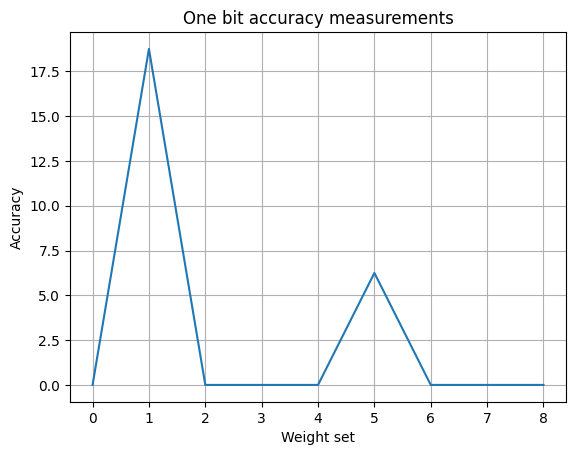

In [34]:
test_results=list()
for i in range(0,9):
  possible_weights=[-4,-2,0,2,4] # Weights to use in the model
  units=[5] # The number of elements in units list represent th number of hidden layers and the value the units of each layer. [5,5] means two hidden layers of 5 units each.
  weights_path=f'/content/drive/MyDrive/one_bit_NAT_{i}.pt'# If you want to load some pretrained weights
  model = MLP(in_feat=n_inputs, num_classes=n_outs,units=units, s=1.0, STEP=True).to(device) # Initialize with STEP== False. It means without step function as activation
  load_model(model,weights_path)
  test_results.append(100-new_evaluate_model(model,train_loader)*100)
plt.title('One bit accuracy measurements')
plt.plot(test_results)
plt.ylabel('Accuracy')
plt.xlabel('Weight set')
plt.grid()
plt.show()

<ipython-input-28-e02185d1a7a8>:37: DeprecationWarning: <class '__main__.BinaryStep'> should not be instantiated. Methods on autograd functionsare all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  self.act_qt = BinaryStep()


Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


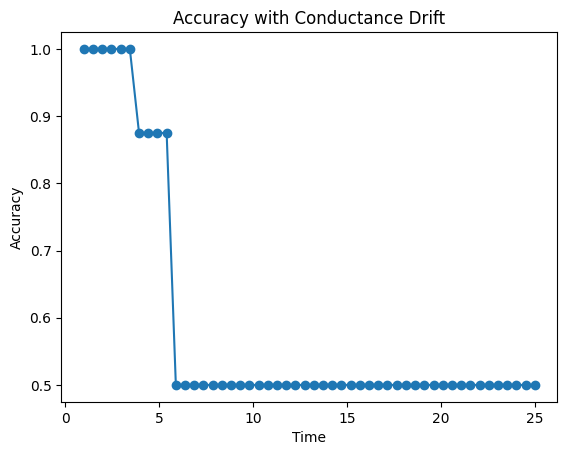

Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


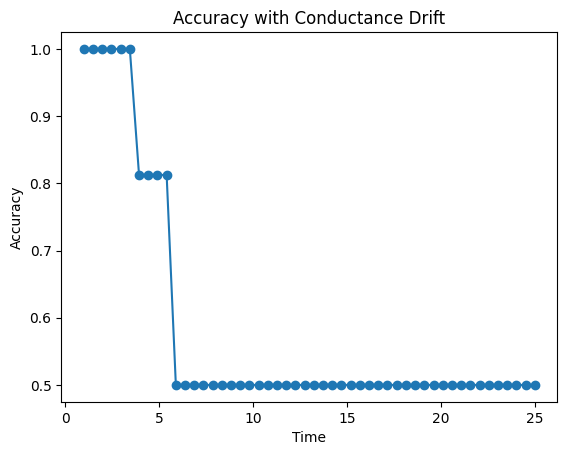

Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


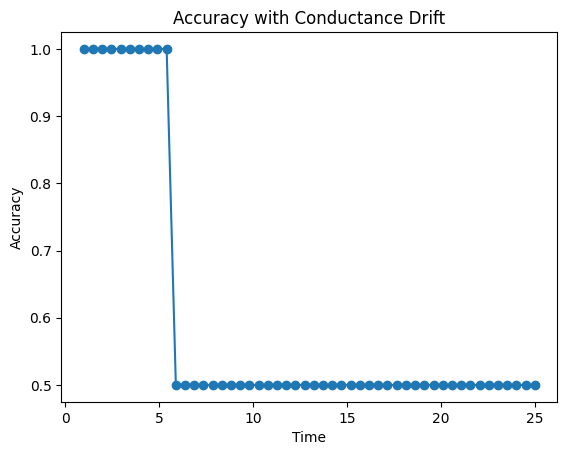

Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


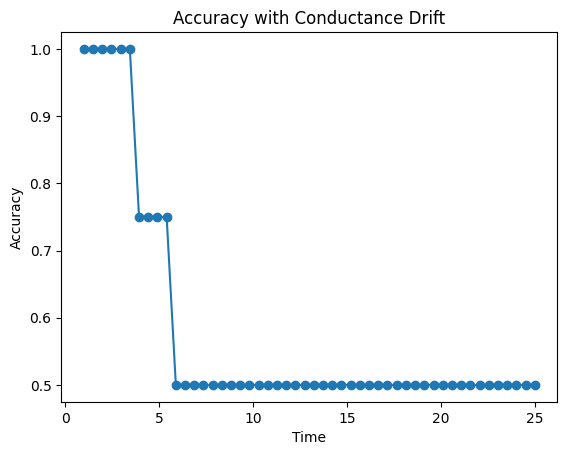

Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


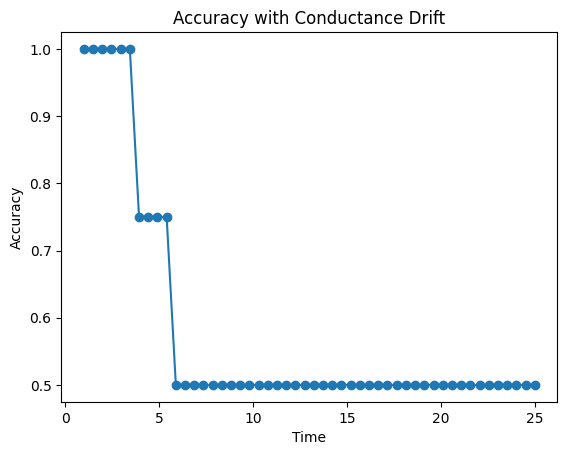

Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


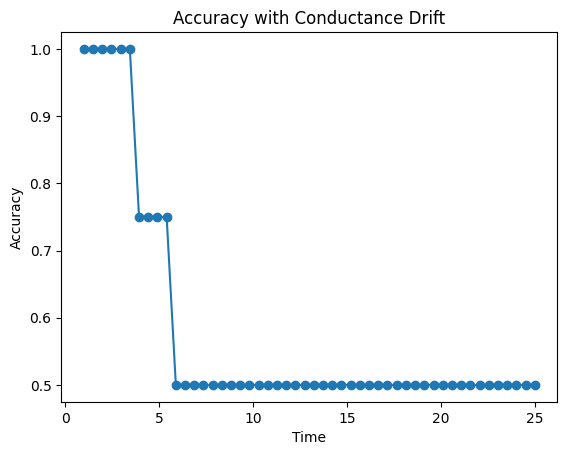

Start LR: 0.01
Start in stage 0
1.0
stage:  1
1.0
stage:  2
1.0
stage:  3
1.0
stage:  4


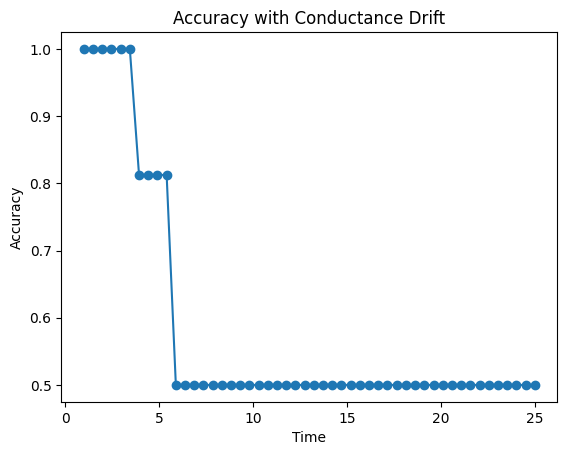

In [37]:
for i in [0,2,3,4,6,7,8]:
  possible_weights=[-4,-2,0,2,4] # Weights to use in the model
  units=[5] # The number of elements in units list represent th number of hidden layers and the value the units of each layer. [5,5] means two hidden layers of 5 units each.
  weights_path=f'/content/drive/MyDrive/one_bit_NAT_{i}.pt'# If you want to load some pretrained weights
  model = MLP(in_feat=n_inputs, num_classes=n_outs,units=units, s=1.0, STEP=False).to(device) # Initialize with STEP== False. It means without step function as activation
  load_model(model,weights_path)

  lr=0.01 # Default
  stage=0
  max_epochs=200000 # Default
  T_max=10000 # Epochs for cosine_scheduler
  warmup_epochs=2000 # 0 if no warmup. I used 2000 and it worked fine.
  base_lr=0.0 # initial learning rate

  ##################################################################################
  ##################################################################################
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_function = nn.BCELoss()

  cosine_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
  warmup_scheduler = WarmupScheduler(
      optimizer,
      warmup_epochs=warmup_epochs,
      base_lr=0.0,  # Starting from 0
      final_lr=lr,  # Target learning rate after warmup
      after_scheduler=cosine_scheduler
  )

  print(f"Start LR: {lr}")
  print(f"Start in stage {stage}")

  now = datetime.now()
  start_time = now.strftime("%Y_%m_%d_%H_%M")

  loss_values=dict()


  best_accuracy=0
  for epoch in range(max_epochs):  # Number of epochs
      model.train()
      total_loss = 0
      total_accuracy = 0
      if stage==0:
        if epoch%3==0:
          for layer in model.layers:
            layer.PTQ=True
          model.STEP=True
        else:
          for layer in model.layers:
            layer.PTQ=False
          model.STEP=True
      if stage==1:
        if epoch%2==0:
          for layer in model.layers:
            layer.PTQ=True
          model.STEP=True
        else:
          for layer in model.layers:
            layer.PTQ=False
          model.STEP=True
      if stage==2:
        if epoch%5==0:
          for layer in model.layers:
            layer.PTQ=False
          model.STEP=True
        else:
          for layer in model.layers:
            layer.PTQ=True
          model.STEP=True
      if stage==3:
          for layer in model.layers:
            layer.PTQ=True
          model.STEP=True
      for x, y in train_loader:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          output = model(x)
          total_accuracy += calculate_accuracy(y, output).item()

          if (total_accuracy/len(train_loader))>best_accuracy:
            best_accuracy=(total_accuracy/len(train_loader))
            print(best_accuracy)
            torch.save(model.state_dict(), f'{Nbits}bits_best_model_{start_time}.pth')
          if (total_accuracy / len(train_loader) == 1.0 and stage==3) or (total_accuracy / len(train_loader) == 1.0 and stage<3):
            print("stage: ",stage+1)
            torch.save(model.state_dict(), f'{Nbits}bits_stage_model_{start_time}.pth')
            best_accuracy=0
            stage=stage+1
            break

          loss = loss_function(output, y)
          loss.backward()
          optimizer.step()
          clip_weights(model, min(possible_weights)-1, max(possible_weights)+1)

          total_loss += loss.item()
          loss_values[total_loss/len(train_loader)]=get_weights(model)


      warmup_scheduler.step()
      if total_accuracy / len(train_loader) == 1 and stage==4:
            break
      if (epoch+1) % 500 == 0:
          average_loss = total_loss / len(train_loader)
          average_accuracy = total_accuracy / len(train_loader)
          print(f'Epoch {epoch+1}, Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}')



  quantize_weights(model)
  time_points = np.linspace(1,25) # for one year
  accuracies = []
  for t in time_points:
      apply_conductance_drift(model, t)
      accuracy=new_evaluate_model(model,train_loader)
      accuracies.append(accuracy)

  plt.figure()
  plt.plot(time_points, accuracies, marker='o')
  plt.xlabel('Time')
  plt.ylabel('Accuracy')
  plt.title('Accuracy with Conductance Drift')
  plt.show()
